In [3]:
import numpy as np
import pandas as pd
import glob
import os

from scipy.io import loadmat
from scipy import stats
import scikit_posthocs as sp

import seaborn as sns
import matplotlib.pyplot as plt

## Slit Sc

## Frequency

In [2]:
direc = r"./dataFolder/Submission 3/Final Submission/Data to be uploaded to Dryad/Figure2/"

In [3]:
file = pd.read_csv(direc + 'merged_TD', sep = "\t")
data = file.loc[:,('Treatment', 'Fly', 'wing_mean.Corleft', 'Average.Corleft', 'Average.Corright')]
data.columns = ['treatment', 'flyID', 'winglength', 'ClippedWingHz', 'IntactWingHz']

bins = [0.3, 0.5, 0.6, 0.7 ,0.9, 1]
data['binned'] = pd.cut(data['winglength'], bins, 
                        labels=np.array([0.3, 0.5, 0.6, 0.7, 0.9]))
new_df = data.drop(['winglength'], axis=1)

In [4]:
data.head()

,treatment,flyID,winglength,ClippedWingHz,IntactWingHz,binned
0,Intact,Fly1,0.821102,93.154528,93.349334,0.7
1,Intact,Fly1,0.666827,101.806114,102.028900,0.6
2,Intact,Fly1,0.573657,108.858352,108.810557,0.5
3,Intact,Fly1,0.461742,93.192249,92.950641,0.3
4,Intact,Fly1,0.391743,84.506527,83.927994,0.3


### compute the largest difference between clipped and intact wings for each fly

In [5]:
new_df = pd.DataFrame(data = None, columns = data.columns)

ii = 0
for trt, df in data.groupby('treatment'):
    for flyID, flydf in df.groupby('flyID'):
        # get the intact and clip wing frequency where the difference is maximum
        temp = flydf.loc[(flydf['IntactWingHz'] - flydf['ClippedWingHz']).abs().idxmax(), :]
        new_df = new_df.append(temp, ignore_index = True)

In [85]:
new_df.head()

,treatment,flyID,winglength,ClippedWingHz,IntactWingHz,binned
0,Intact,Fly1,0.391743,84.506527,83.927994,0.3
1,Intact,Fly2,1.000000,109.348125,112.487110,0.9
2,Intact,Fly3,0.759073,119.158525,119.983680,0.7
3,Intact,Fly5,0.620712,117.361145,117.687945,0.6
4,Intact,Fly6,0.720811,141.340205,140.790750,0.7


In [7]:
# test the alternate hypothesis that intact wings lesser frequency as compared to that of the clipped wings

for trt, df in new_df.groupby('treatment'):
    clipw = df.ClippedWingHz.values  
    intactw = df.IntactWingHz.values
    U, p = stats.wilcoxon(intactw,clipw, alternative = 'less', mode = 'approx')
    print('%s thorax contralateral wings, p value is %0.3f and U value is %0.3f' %(trt, p, U))

Intact thorax contralateral wings, p value is 0.623 and U value is 12.000
Slit thorax contralateral wings, p value is 0.022 and U value is 0.000


C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


<AxesSubplot:xlabel='treatment', ylabel='freq'>

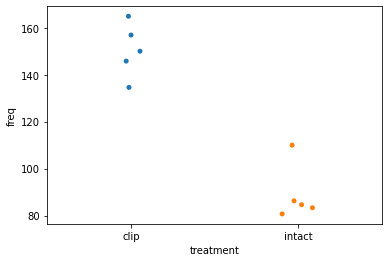

In [8]:
temp = pd.DataFrame({'clip': clipw, 'intact': intactw})
temp_sns = pd.melt(temp, value_vars = ['clip', 'intact'],
                  value_name = 'freq',
                  var_name = 'treatment')
sns.stripplot(x = 'treatment', y = 'freq', data = temp_sns)

In [9]:
SlitSc_SumStat = pd.DataFrame(data = None,
                             index = data.binned.unique(),
                             columns = data.treatment.unique())

In [10]:
# stats for each winglength

for trt, df_trt in data.groupby('treatment'):
    for binned, df_binned in df_trt.groupby('binned'):
        clipw = df_binned.ClippedWingHz.values  
        intactw = df_binned.IntactWingHz.values
        U, p = stats.wilcoxon(intactw, clipw, alternative = 'two-sided')
        SlitSc_SumStat.loc[binned,trt] = p
#         print('%s and %s, p value is %0.3f and U value is %0.8f' %(trt, binned, p, U))

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:2957: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "


In [11]:
SlitSc_SumStat

,Intact,Slit
0.7,0.248864,0.317311
0.6,0.875,0.125
0.5,0.345448,0.125
0.3,0.03125,0.108809
0.9,0.0796158,0.59298


## amplitude

In [91]:
# Slit Sc
df_amp = pd.read_csv('./dataFolder/AmplitudeAnalysis/v2/Slit_sc/median_summary_edited.csv')
df_amp.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,flyID,body,med_amplitude,treatment,binned,bodypart
0,0,0,0,fly1,LW,103.677600,0.450367,"(0.3, 0.5]",clip
1,1,1,1,fly1,RW,96.487214,0.450367,"(0.3, 0.5]",intact
2,2,2,2,fly1,LW,148.977524,0.617825,"(0.6, 0.7]",clip
3,3,3,3,fly1,RW,114.640444,0.617825,"(0.6, 0.7]",intact
4,4,4,4,fly1,LW,150.204065,0.719372,"(0.7, 0.9]",clip


In [92]:
for wing, s_df in df_amp.groupby('bodypart'):
    U, p = stats.kruskal(*[group["med_amplitude"].values for name, group in s_df.groupby("binned")])
    print('%s has a p value of %0.5f and U values of %0.3f' %(wing, p, U))
    if p < 0.05:
        print(sp.posthoc_dunn(s_df, val_col='med_amplitude', group_col='binned'))

clip has a p value of 0.06778 and U values of 8.746
intact has a p value of 0.18357 and U values of 6.216


In [89]:
# intact thorax
df_amp = pd.read_csv('./dataFolder/AmplitudeAnalysis/v2/asymmetric_wings/median_summary_edited.csv')
df_amp.head()

,Unnamed: 0,Unnamed: 0.1,Unnamed: 0.1.1,flyID,body,med_amplitude,treatment,binned,bodypart
0,0,0,0,fly1,LW,106.300374,0.391743,"(0.3, 0.5]",clip
1,1,1,1,fly1,RW,141.388610,0.391743,"(0.3, 0.5]",intact
2,2,2,2,fly1,LW,108.509719,0.461742,"(0.3, 0.5]",clip
3,3,3,3,fly1,RW,137.794417,0.461742,"(0.3, 0.5]",intact
4,4,4,4,fly1,LW,129.176719,0.573657,"(0.5, 0.6]",clip


In [90]:
for wing, s_df in df_amp.groupby('bodypart'):
    U, p = stats.kruskal(*[group["med_amplitude"].values for name, group in s_df.groupby("binned")])
    print('%s has a p value of %0.5f and U values of %0.3f' %(wing, p, U))
    if p < 0.05:
        print(sp.posthoc_dunn(s_df, val_col='med_amplitude', group_col='binned'))

clip has a p value of 0.00021 and U values of 21.899
            (0.3, 0.5]  (0.5, 0.6]  (0.6, 0.7]  (0.7, 0.9]  (0.9, 1.0]
(0.3, 0.5]    1.000000    0.093803    0.025797    0.000553    0.000018
(0.5, 0.6]    0.093803    1.000000    0.418836    0.071458    0.005565
(0.6, 0.7]    0.025797    0.418836    1.000000    0.486447    0.108606
(0.7, 0.9]    0.000553    0.071458    0.486447    1.000000    0.259076
(0.9, 1.0]    0.000018    0.005565    0.108606    0.259076    1.000000
intact has a p value of 0.21822 and U values of 5.755


## EpiRidge Cut

In [4]:
direc= r"./dataFolder/Submission 3/Final Submission/Data to be uploaded to Dryad/EpiRidgeCut_Figure3/"

In [5]:
data = pd.read_csv(direc + 'compiledDataForAggregratePlots.csv')

In [6]:
data.head()

,Unnamed: 0,flyID,treatment,winglength,wingHz,leftHalHz,rightHalHz,binned
0,0,fly1,cutwing1_1,0.82,138.095238,138.095238,138.095238,"(0.7, 0.9]"
1,1,fly1,cutwing2_1,0.72,132.321429,132.797619,132.310924,"(0.7, 0.9]"
2,2,fly1,cutwing3_1,0.58,151.648352,151.904762,151.831502,"(0.5, 0.6]"
3,3,fly1,cutwing4_1,0.50,138.387470,130.766537,137.388943,"(0.4, 0.5]"
4,4,fly1,cutwing5_1,0.38,187.272727,124.550654,125.486992,"(0.3, 0.4]"


In [8]:
# remove fly 6 from stats
# subset = data[(data.binned == '(0.5, 0.6]') & (data.flyID != 'fly6')]
# subset

,Unnamed: 0,flyID,treatment,winglength,wingHz,leftHalHz,rightHalHz,binned
2,2,fly1,cutwing3_1,0.58,151.648352,151.904762,151.831502,"(0.5, 0.6]"
8,8,fly2,cutwing3_1,0.53,135.773809,81.405410,136.190476,"(0.5, 0.6]"
14,14,fly3,cutwing3_1,0.55,130.644258,121.367819,130.525210,"(0.5, 0.6]"
20,20,fly5,cutwing3_1,0.55,152.289377,77.495974,90.231126,"(0.5, 0.6]"
25,25,fly6,cutwing3_1,0.51,118.201324,74.224054,108.497306,"(0.5, 0.6]"


In [10]:
# subdata = data.loc[data.flyID != 'fly6', :]
subdata = data.copy()

In [11]:
# do wilcoxon for each winglength

EpiRidge_SumStats = pd.DataFrame(data = None,
                                index = data.binned.unique(),
                                columns = ['RidgeCutHal-wing', 'controlHal-wing'])

for binned, df_binned in subdata.groupby('binned'):
#     print(binned)
    wing = df_binned.wingHz.values
    left = df_binned.leftHalHz.values
    right = df_binned.rightHalHz.values

    U, p = stats.wilcoxon(wing, left, alternative='greater', mode = 'approx')
    EpiRidge_SumStats.loc[binned, 'RidgeCutHal-wing']= p
#     print('wing and ridge cut haltere, p value is %0.5f and U value %0.3f' %(p,U))

    U, p = stats.wilcoxon(wing, right, alternative='greater', mode = 'approx')
    EpiRidge_SumStats.loc[binned, 'controlHal-wing']= p
#     print('wing and control haltere, p value is %0.5f and U value %0.3f' %(p, U))

C:\Users\Tanvi\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\stats\morestats.py:2971: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


In [12]:
EpiRidge_SumStats

,RidgeCutHal-wing,controlHal-wing
"(0.7, 0.9]",0.458256,0.541744
"(0.5, 0.6]",0.0398079,0.250092
"(0.4, 0.5]",0.0215572,0.0215572
"(0.3, 0.4]",0.0215572,0.0215572
"(0.9, 1.0]",0.962632,0.553631
"(0.6, 0.7]",0.0398079,0.657085


In [9]:
EpiRidge_SumStats.to_csv(direc + 'summaryStats_withoutFly6.csv')

## loaded haltere

In [100]:
direc = r"./dataFolder/Submission 3/Final Submission/Data to be uploaded to Dryad/HaltereLoading_Figure5/"

In [101]:
data = pd.read_csv(direc + 'compiledDataForAggregratePlots.csv')

In [102]:
data.head()

,Unnamed: 0,flyID,wingHz,leftHalHz,rightHalHz,treatment
0,0,fly1,96.904762,97.142857,96.904762,intacthaltere
1,1,fly1,102.130326,102.393484,102.393484,loadedhaltere1
2,2,fly1,112.452700,107.893285,112.125903,loadedhaltere2
3,3,fly1,109.064327,49.968041,109.356725,loadedhaltere3
4,4,fly1,109.064327,109.356725,109.064327,removedload


#### wilcoxon test

In [104]:
# alternative hupothesis is that left/right haltere is less than wing

loadedHal_summaryStats = pd.DataFrame(data = None, 
                                      index = data.treatment.unique(), 
                                      columns = ['loadedHal-wing', 'controlHal-wing'])

for trt, df in data.groupby('treatment'):
    rightHal= df.rightHalHz.values
    leftHal = df.leftHalHz.values
    wing = df.wingHz.values

    U, p = stats.wilcoxon(rightHal, wing, alternative='less', mode = 'approx')
#     print('left-right haltere, p value is %0.5f and U value is %0.5f' %(p, U))
    loadedHal_summaryStats.loc[trt, 'controlHal-wing'] = p

    U, p = stats.wilcoxon(leftHal, wing, alternative='less', mode = 'approx')
#     print('left haltere-wing, p value is %0.5f and U value is %0.5f' %(p, U))
    loadedHal_summaryStats.loc[trt, 'loadedHal-wing'] = p
loadedHal_summaryStats.to_csv(r'./dataFolder/Submission 3/Final Submission/Data to be uploaded to Dryad/HaltereLoading_Figure5/summaryStats.csv')

In [105]:
loadedHal_summaryStats

,loadedHal-wing,controlHal-wing
intacthaltere,0.875568,0.827384
loadedhaltere1,0.963031,0.986146
loadedhaltere2,0.0138539,0.662929
loadedhaltere3,0.0138539,0.986146
removedload,0.231536,0.342915


In [ ]:
data[data.treatment == 'loadedhaltere2']

In [106]:
loadedHal_summaryStats.to_csv(direc + 'summaryStats.csv')

## amplitude for both epi and haltere

In [10]:
data_epi = pd.read_csv('./dataFolder/AmplitudeAnalysis/v2/epi_ridge_cut/median_summary.csv')

In [11]:
data_epi.head()

,Unnamed: 0,Unnamed: 0.1,flyID,body,med_amplitude,winglength,binned
0,0,0,fly1,LH,124.793194,0.38,"(0.3, 0.4]"
1,1,1,fly1,LW,86.794979,0.38,"(0.3, 0.4]"
2,2,2,fly1,RH,123.358511,0.38,"(0.3, 0.4]"
3,3,3,fly1,RW,107.727884,0.38,"(0.3, 0.4]"
4,4,4,fly1,LH,148.176682,0.50,"(0.4, 0.5]"


In [12]:
# drop fly 8 and 9 
data_epi.drop(data_epi.loc[data_epi.flyID.isin(['fly8', 'fly9']), :].index, inplace = True)

In [15]:
data_epi.flyID.unique()

array(['fly1', 'fly2', 'fly3', 'fly5', 'fly7'], dtype=object)

In [13]:
for wing, s_df in data_epi.groupby('body'):
    U, p = stats.kruskal(*[group["med_amplitude"].values for name, group in s_df.groupby("binned")])
    print('%s has a p value of %0.5f and U values of %0.3f' %(wing, p, U))
    if p < 0.05:
        print(sp.posthoc_dunn(s_df, val_col='med_amplitude', group_col='binned'))

LH has a p value of 0.14826 and U values of 8.148
LW has a p value of 0.00844 and U values of 15.495
            (0.3, 0.4]  (0.4, 0.5]  (0.5, 0.6]  (0.6, 0.7]  (0.7, 0.9]  \
(0.3, 0.4]    1.000000    0.224681    0.018083    0.005211    0.003510   
(0.4, 0.5]    0.224681    1.000000    0.201390    0.083514    0.077281   
(0.5, 0.6]    0.018083    0.201390    1.000000    0.667340    0.741720   
(0.6, 0.7]    0.005211    0.083514    0.667340    1.000000    0.887675   
(0.7, 0.9]    0.003510    0.077281    0.741720    0.887675    1.000000   
(0.9, 1.0]    0.001179    0.031336    0.452013    0.764930    0.629931   

            (0.9, 1.0]  
(0.3, 0.4]    0.001179  
(0.4, 0.5]    0.031336  
(0.5, 0.6]    0.452013  
(0.6, 0.7]    0.764930  
(0.7, 0.9]    0.629931  
(0.9, 1.0]    1.000000  
RH has a p value of 0.47061 and U values of 4.570
RW has a p value of 0.02403 and U values of 12.931
            (0.3, 0.4]  (0.4, 0.5]  (0.5, 0.6]  (0.6, 0.7]  (0.7, 0.9]  \
(0.3, 0.4]    1.000000    0.43

In [14]:
# at each bin compare left and right wing

sub_df = data_epi[data_epi['body'].isin(['LW', 'RW'])]

for binned, s_df in sub_df.groupby('binned'):
    U, p = stats.wilcoxon(*[group["med_amplitude"].values for name, group in s_df.groupby("binned")])
    print('%s had p value of %0.5f and Statistic of %0.3f' %(binned, p, U))

(0.3, 0.4] had p value of 0.00781 and Statistic of 0.000
(0.4, 0.5] had p value of 0.00195 and Statistic of 0.000
(0.5, 0.6] had p value of 0.00781 and Statistic of 0.000
(0.6, 0.7] had p value of 0.00781 and Statistic of 0.000
(0.7, 0.9] had p value of 0.00049 and Statistic of 0.000
(0.9, 1.0] had p value of 0.00195 and Statistic of 0.000


In [129]:
data_hal = pd.read_csv('./dataFolder/AmplitudeAnalysis/v2/haltere_loading/median_summary.csv')
data_hal.head()

,Unnamed: 0,flyID,body,med_amplitude,winglength
0,0,fly1,LH,152.341363,intacthalteres
1,1,fly1,LW,158.869661,intacthalteres
2,2,fly1,RH,144.618297,intacthalteres
3,3,fly1,RW,156.706477,intacthalteres
4,4,fly1,LH,149.809164,loadedhaltere1


In [130]:
for wing, s_df in data_hal.groupby('body'):
    U, p = stats.kruskal(*[group["med_amplitude"].values for name, group in s_df.groupby("winglength")])
    print('%s has a p value of %0.5f and U values of %0.3f' %(wing, p, U))
    if p < 0.05:
        print(sp.posthoc_dunn(s_df, val_col='med_amplitude', group_col='binned'))

LH has a p value of 0.81265 and U values of 1.578
LW has a p value of 0.18039 and U values of 6.262
RH has a p value of 0.18039 and U values of 6.262
RW has a p value of 0.17834 and U values of 6.292


In [131]:
# at each bin compare left and right wing

sub_df = data_hal[data_hal['body'].isin(['LW', 'RW'])]

for binned, s_df in sub_df.groupby('winglength'):
    U, p = stats.wilcoxon(*[group["med_amplitude"].values for name, group in s_df.groupby("body")])
    print('%s had p value of %0.5f and Statistic of %0.3f' %(binned, p, U))

intacthalteres had p value of 0.06250 and Statistic of 1.000
loadedhaltere1 had p value of 1.00000 and Statistic of 10.000
loadedhaltere2 had p value of 0.06250 and Statistic of 1.000
loadedhaltere3 had p value of 0.56250 and Statistic of 7.000
removedload had p value of 1.00000 and Statistic of 10.000
